adapting: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 800 of 800, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
alpha  mean =   0.0, 95% credible interval [ 0.0  0.0]
beta   mean =   3.3, 95% credible interval [ 3.3  3.4]
sigma  mean =   1.4, 95% credible interval [ 1.2  1.6]


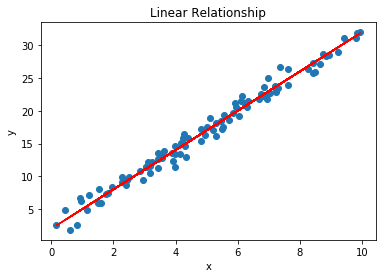

In [19]:
"""
Header--------------------

Fitting a linear regression in JAGS

In this code we generate some data from a simple linear regression model and fit is using jags. 
We then intepret the output.


"""

import pyjags
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.tools.plotting import *

"""
Maths -------------------------------------------------------------------

Description of the Bayesian model fitted in this file
Notation:
y_i = repsonse variable for observation t=i,..,N
x_i = explanatory variable for obs i
alpha, beta = intercept and slope parameters to be estimated
sigma = residual standard deviation

Likelihood:
y[i] ~ N(alpha + beta * x[i], sigma^2)
Prior
alpha ~ N(0,100) - vague priors
beta ~ N(0,100)
sigma ~ U(0,10) = tau
"""

# Simulate data:
np.random.seed(123)

N = 100
alpha = 2
beta = 3
sigma = 1

x = np.random.uniform(0, 10, size=N) # Draw samples from a uniform distribution
y = np.random.normal(alpha + x*beta, sigma, size=N) # Draw random samples from a normal (Gaussian) distribution.


# Creating a plot:
plt.scatter(x,y)
plt.ylabel('y')
plt.xlabel('x')
plt.title('Linear Relationship')
plt.plot(x,alpha + beta * x, c= "red")


# JAGS CODE ----------------------------------------------------
# Jags code to fit the model to the simulated data

code = '''
model {
    for (i in 1:N) {
        y[i] ~ dnorm(alpha + beta * x[i], tau)
    }
    # Priors
    alpha ~ dunif(0, 1e-2)
    beta ~ dnorm(0, 1e-2)
    tau <- 1 / sigma^2
    sigma ~ dunif(0, 10)
}
'''

# Set up the data:
model = pyjags.Model(code, data=dict(x=x, y=y, N=N), chains=4) # Chains = Number of different starting positions

# Number of iterations to remove at start and amount of thinning
model.sample(200, vars=[], thin = 2)

# Choose the parameters to watch and iterations:
samples = model.sample(1000, vars=['alpha', 'beta', 'sigma'])

"""
Simulated results ----------------------------------------------------------------
"""
def summary(samples, varname, p=95):
    values = samples[varname]
    ci = np.percentile(values, [100-p, p])
    print('{:<6} mean = {:>5.1f}, {}% credible interval [{:>4.1f} {:>4.1f}]'.format(
      varname, np.mean(values), p, *ci))

for varname in ['alpha', 'beta', 'sigma']:
    summary(samples, varname)


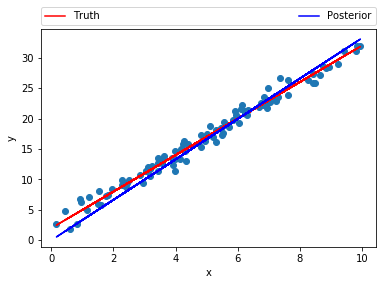

In [20]:
# Create a plot of the posterior mean regression line
alpha_mean = 0.005105
beta_mean = 3.321697

# Creating a plot:
plt.scatter(x,y)
plt.ylabel('y')
plt.xlabel('x')
plt.plot(x,alpha + beta * x, c= "red", label = "Truth")
plt.plot(x, alpha_mean + beta_mean * x, c = "blue",label = "Posterior")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
# Blue and red lines should be pretty close

/Users/alaninglis/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/alaninglis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.


Mean:
Variable
alpha    0.005208
beta     3.321889
sigma    1.385899
dtype: float64
Credible Intervals:
Variable     alpha      beta     sigma
0.05      0.000613  3.280943  1.232024
0.95      0.009547  3.362748  1.562354


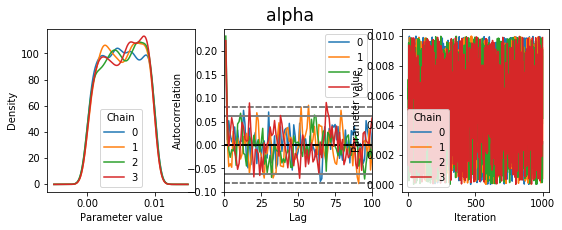

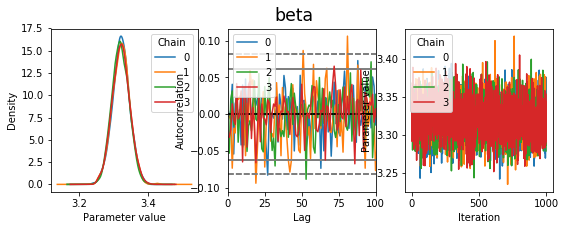

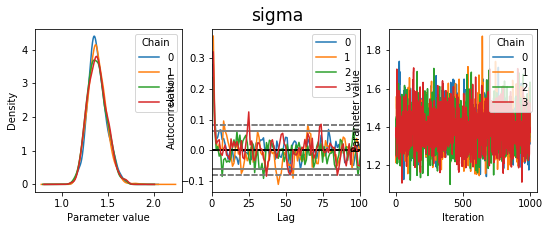

In [21]:
### Another method for displaying the results
### This section needs work to fix the plots

# Use pandas three dimensional Panel to represent the trace:
trace = pd.Panel({k: v.squeeze(0) for k, v in samples.items()})
trace.axes[0].name = 'Variable'
trace.axes[1].name = 'Iteration'
trace.axes[2].name = 'Chain'
 
# Point estimates:
print("Mean:")
print(trace.to_frame().mean())
 

# Bayesian equal-tailed 95% credible intervals:
print("Credible Intervals:")
print(trace.to_frame().quantile([0.05, 0.95]))
 

def plot(trace, var):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    fig.suptitle(var, fontsize='xx-large')
 
    # Marginal posterior density estimate:
    trace[var].plot.density(ax=axes[0])
    axes[0].set_xlabel('Parameter value')
    axes[0].locator_params(tight=True)
 
    # Autocorrelation for each chain:
    axes[1].set_xlim(0, 100)
    for chain in trace[var].columns:
        autocorrelation_plot(trace[var,:,chain], axes[1], label=chain)
 
    # Trace plot:
    axes[2].set_ylabel('Parameter value')
    trace[var].plot(ax=axes[2])
 
   
 # Display diagnostic plots
for var in trace:
    plot(trace, var)
